In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
# import cv2
from keras.models import load_model
import tensorflow as tf
from keras import optimizers
import keras
import segmentation_models as sm
import metric
from commons import *
from PIL import Image

from architecture import create_model, create_callbacks


BACKUP_MODEL_PATH = "./../Models/backup.h5"
BACKUP_HISTORY_PATH = "./../Models/backup.csv"
seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 3

ROOT = "./../Data/karlsruhe/"
TRAIN_DIR = "_Train512/"

USE_AUGMENTATION = True

Segmentation Models: using `keras` framework.


In [2]:
model = create_model(IMAGE_HEIGHT, IMAGE_WIDTH, filter_factor = 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_01 (Conv2D)             (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d_01[0][0]']              
 alization)                     )                                                             

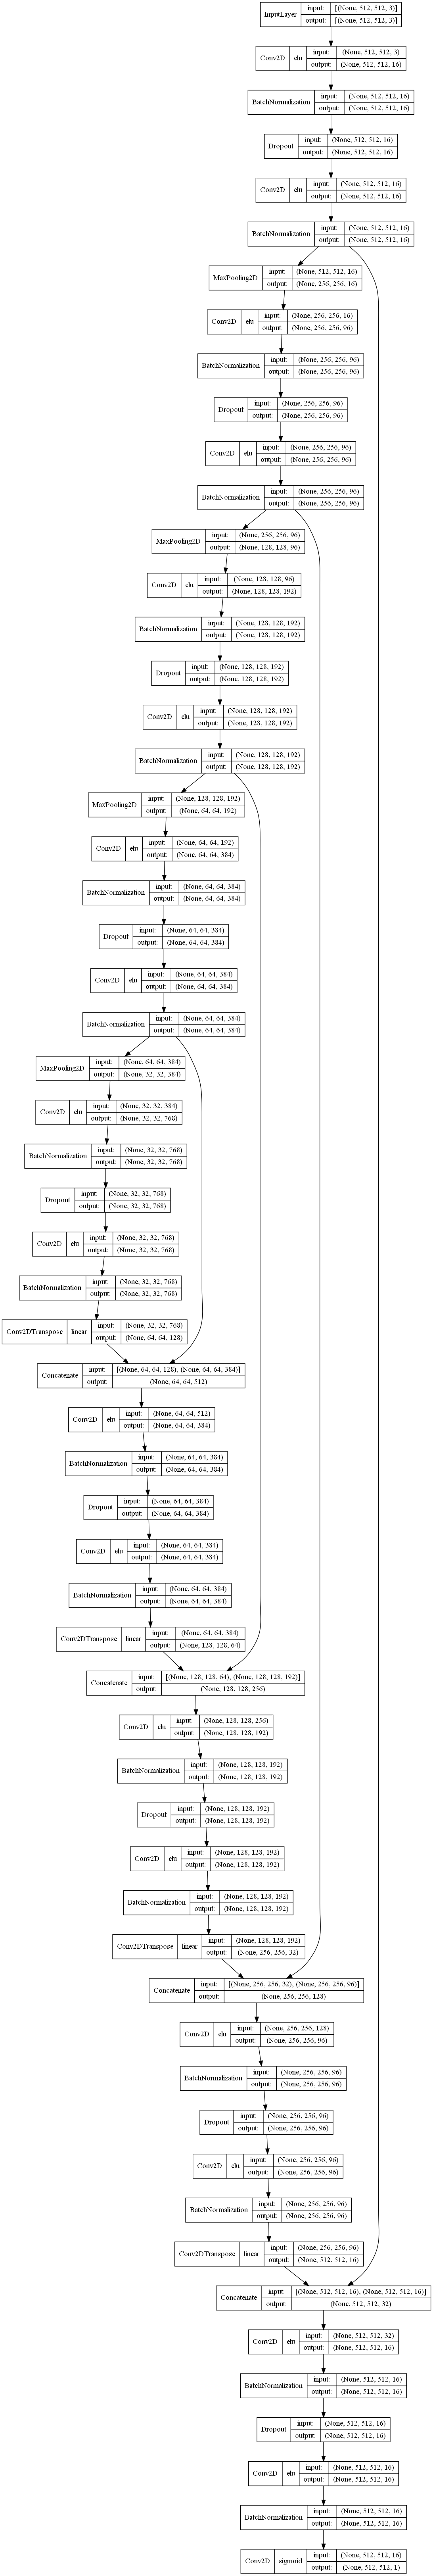

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='./../Models/unet_struct.png',show_shapes=True, show_layer_activations=True, show_layer_names=False)

from IPython.display import Image as IP_Image
IP_Image(retina=True, filename='./../Models/unet_struct.png')

Found 9 files belonging to 1 classes.
Using 7 files for training.
Found 9 files belonging to 1 classes.
Using 2 files for validation.
Found 9 files belonging to 1 classes.
Using 7 files for training.
Found 9 files belonging to 1 classes.
Using 2 files for validation.
ITERATION XY BEFORE 0
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.


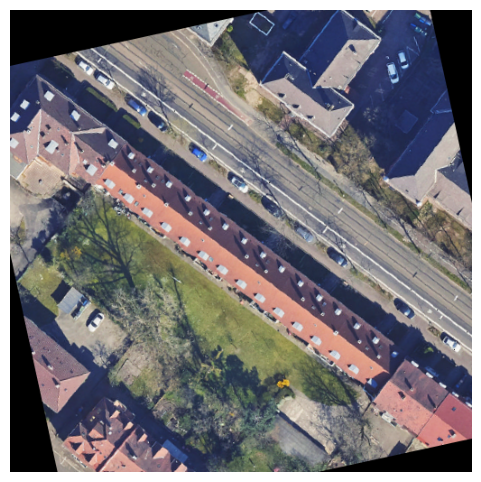

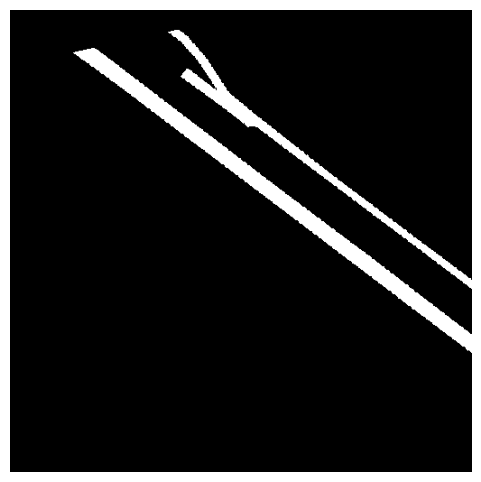

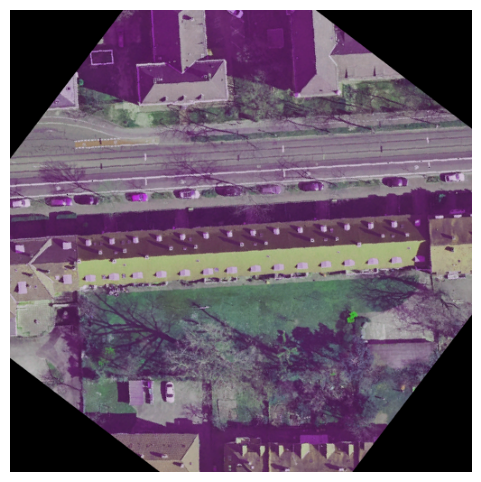

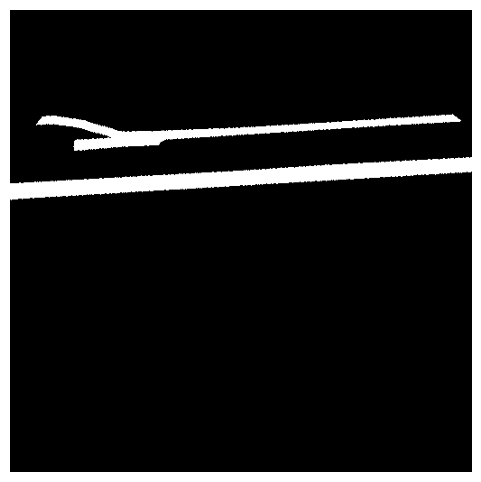

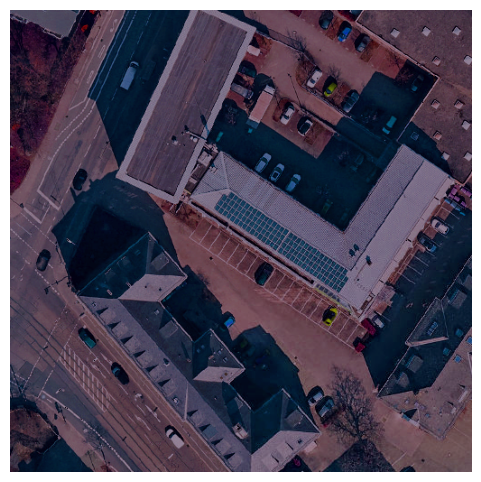

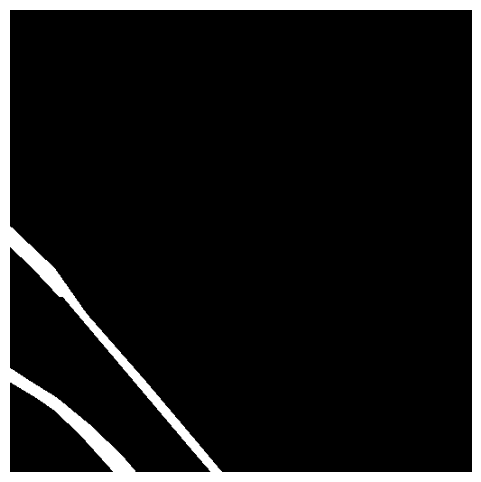

In [4]:
opt = keras.optimizers.Adam(LEARNING_RATE)
callbacks = create_callbacks(BACKUP_MODEL_PATH, BACKUP_HISTORY_PATH)

model.compile(
      optimizer=opt,
      loss= sm.losses.DiceLoss(),
      metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True)

train_gen, val_gen = train_val_generator(IMAGE_WIDTH, IMAGE_HEIGHT, ROOT, TRAIN_DIR, BATCH_SIZE, seed,
                                         use_aug=USE_AUGMENTATION)

image, label = next(iter(train_gen.data))

for image, label in zip(image, label):

    image, label = image.numpy(), label.numpy()

    from PIL import Image
    #Image.fromarray(np.uint8(image)).show("title")
    from matplotlib import pyplot as plt

    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(np.uint8(image))
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(label)
    plt.show()

In [4]:
"""Load Model backup to resume training after crash or break or for pretraining"""
model = load_model(BACKUP_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore(), "quality":metric.quality()})

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("steps per epoch:", train_gen.samplesPerBatch, "steps per validation:", val_gen.samplesPerBatch,)

history = model.fit(train_gen.data,  validation_data=val_gen.data, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

Num GPUs Available:  1
steps per epoch: 91 steps per validation: 8
Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 0.9859 - iou_score: 0.0068 - f1-score: 0.0141 - quality: 0.0245
Epoch 1: val_loss improved from inf to 0.98277, saving model to ./../Models\backup.h5
91/91 [==============================] - 54s 536ms/step - loss: 0.9859 - iou_score: 0.0068 - f1-score: 0.0141 - quality: 0.0245 - val_loss: 0.9828 - val_iou_score: 0.0087 - val_f1-score: 0.0177 - val_quality: 0.0290 - lr: 1.0000e-04
Epoch 2/100
35/91 [==========>...................] - ETA: 27s - loss: 0.9903 - iou_score: 0.0056 - f1-score: 0.0097 - quality: 0.0199

KeyboardInterrupt: 

Time of saving model: 2022-11-11 03:39:59.068012


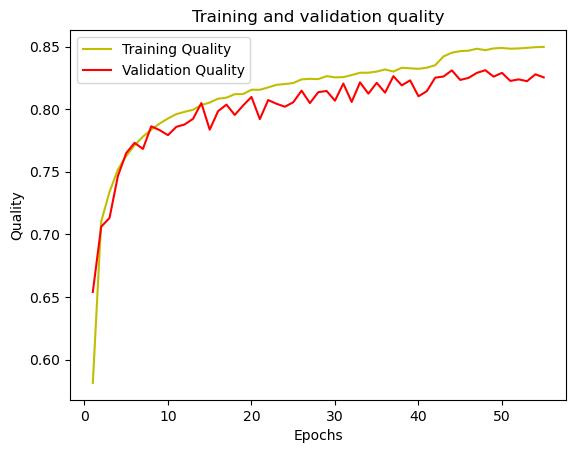

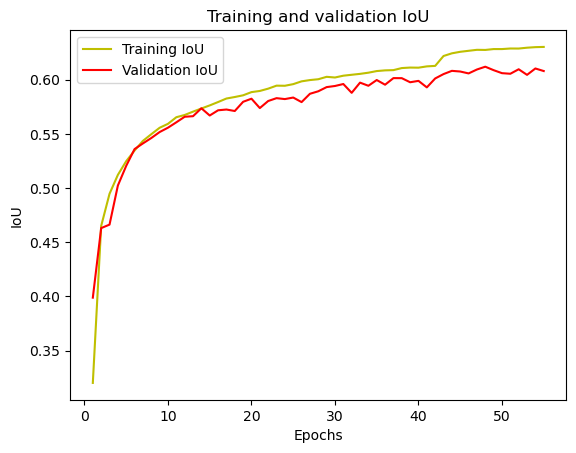

In [5]:
model_path = "./../Models/Roads/triple-param/road_mapper_scratch_Combined_Aug.h5"
save_model(model, model_path=model_path, csv_history_path_to_delete=BACKUP_HISTORY_PATH)
plot_history(history, model_path)

In [6]:
import os
os.system("shutdown /s /t 1")

0